### 1. Importing modules

In [1]:
import pandas as pd
import os
import random
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import numpy as np

### 2. Reading data

In [2]:
current_folder = os.getcwd()
data_path = f"{current_folder}/2023-citibike-tripdata"
data_file_names = os.listdir(data_path)

In [3]:
data = pd.DataFrame()
# for file in data_file_names:
for file in data_file_names:
    data = pd.concat([data, pd.read_csv(f'{data_path}/{file}')])

    break

print('Dimension of data is', data.shape)
data.head(2)

C:\Users\aabdu\AppData\Local\Temp\ipykernel_48328\200019043.py:4: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.concat([data, pd.read_csv(f'{data_path}/{file}')])


Dimension of data is (1000000, 13)


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,DC1CB984821DFFF7,classic_bike,2023-01-07 15:36:53.430,2023-01-07 15:39:45.406,Vesey St & Church St,5216.06,Albany St & Greenwich St,5145.02,40.712220,-74.010472,40.709267,-74.013247,member
1,C00CA02971557F16,classic_bike,2023-01-04 19:23:01.234,2023-01-04 19:34:57.151,Lispenard St & Broadway,5391.06,St Marks Pl & 1 Ave,5626.13,40.719392,-74.002472,40.727791,-73.985649,member


### 3. Cleaning data

In [4]:
data.isna().sum()

ride_id                  0
rideable_type            0
started_at               0
ended_at                 0
start_station_name      57
start_station_id        57
end_station_name      4313
end_station_id        4313
start_lat                0
start_lng                0
end_lat               1221
end_lng               1221
member_casual            0
dtype: int64

In [5]:
# Removing rides that are a loop
data = data[(data.start_station_id != data.end_station_id)&(data.start_station_name != data.end_station_name)]

# Removing rides with no end station or no start stations
data = data[data.end_station_name.notna()]


In [6]:
# Cleaning dtypes
data = data.astype({'ride_id': 'string', 
             'rideable_type': 'category', 
            #  'start_station_name': 'category', 
             'start_station_id': 'category', 
            #  'end_station_name': 'category',
             'end_station_id': 'category', 
             'start_lat': 'float',
             'start_lng': 'float',
             'end_lat': 'float',
             'end_lng': 'float',
             'member_casual': 'category'})

data.started_at = pd.to_datetime(data.started_at)
data.ended_at = pd.to_datetime(data.ended_at)

data.dtypes

ride_id               string[python]
rideable_type               category
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_name            object
start_station_id            category
end_station_name              object
end_station_id              category
start_lat                    float64
start_lng                    float64
end_lat                      float64
end_lng                      float64
member_casual               category
dtype: object

### 4. Picking 300 stations at random
The 300 stations will act as either starting or ending stations to build our network

In [7]:
random.seed(70)

start_stations = data[['start_station_name','start_lat','start_lng']]
start_stations.columns=['station','lat','lng']
end_stations = data[['end_station_name','end_lat','end_lng']]
end_stations.columns=['station','lat','lng']
stations = pd.concat([start_stations, end_stations]).drop_duplicates()
random_numbers = random.sample(range(1, len(stations),1), 50)
stations = stations.iloc[random_numbers].reset_index(drop=True).reset_index(names='station_id')
stations.loc[:,'station_id'] = stations.loc[:,'station_id'] + 1
stations

,station_id,station,lat,lng
0,1,6 Ave & Broome St,40.724539,-74.004625
1,2,Thompson St & Bleecker St,40.728235,-73.999700
2,3,University Pl & E 14 St,40.734733,-73.992044
3,4,W 42 St & 6 Ave,40.755205,-73.984420
4,5,Greene Ave & Nostrand Ave,40.688337,-73.950994
5,6,11 Ave & Prospect Ave,40.656327,-73.977298
6,7,Prospect Pl & Nostrand Ave,40.674275,-73.950389
7,8,Leonard St & Church St,40.717577,-74.005618
8,9,E 116 St & 2 Ave,40.796906,-73.937085
9,10,West End Ave & W 60 St,40.772633,-73.989929


In [8]:
# Taking a subset of bike trips that either begin or end at one of the 300 stations
data = data[(data.start_station_name.isin(stations.station)) & (data.end_station_name.isin(stations.station))]
data = data.reset_index(drop=True)
data.head(5)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,F1593ADE66786F7C,electric_bike,2023-01-05 10:41:33.830,2023-01-05 11:20:58.328,Broadway & W 61 St,7014.12,Bayard St & Leonard St,5442.05,40.770311,-73.982088,40.719156,-73.948854,casual
1,6856B640B43941B0,classic_bike,2023-01-19 12:55:09.767,2023-01-19 12:56:25.936,Broadway & E 14 St,5905.12,University Pl & E 14 St,5905.14,40.734546,-73.990741,40.734814,-73.992085,member
2,AF724BC5F08A9947,classic_bike,2023-01-19 12:49:48.840,2023-01-19 12:51:49.855,Broadway & E 14 St,5905.12,University Pl & E 14 St,5905.14,40.734546,-73.990741,40.734814,-73.992085,member
3,AFE523726BE25FC4,electric_bike,2023-01-03 11:30:56.805,2023-01-03 11:32:57.980,Broadway & E 14 St,5905.12,University Pl & E 14 St,5905.14,40.734483,-73.990658,40.734814,-73.992085,member
4,D9C2204519212945,electric_bike,2023-01-19 22:48:50.531,2023-01-19 22:56:23.283,Broadway & E 14 St,5905.12,University Pl & E 14 St,5905.14,40.734546,-73.990741,40.734814,-73.992085,member


In [9]:
# Understanding the demand of entire biking routes and assigning stations with their ids
route_demand = data.value_counts(['start_station_name','end_station_name'])
route_demand = route_demand.reset_index()
route_demand.loc[:, 'start_stn_id'] = route_demand.start_station_name.map(dict(zip(stations.station,stations.station_id)))
route_demand.loc[:, 'end_stn_id'] = route_demand.end_station_name.map(dict(zip(stations.station,stations.station_id)))
route_demand

,start_station_name,end_station_name,count,start_stn_id,end_stn_id
0,E 40 St & Park Ave,E 27 St & Park Ave S,201,13,29
1,E 27 St & Park Ave S,E 40 St & Park Ave,185,29,13
2,E 39 St & 2 Ave,E 40 St & Park Ave,91,37,13
3,Broadway & W 56 St,Broadway & W 51 St,87,24,20
4,West End Ave & W 60 St,Broadway & W 51 St,74,10,20
...,...,...,...,...,...
348,E 47 St & 2 Ave,W 89 St & Columbus Ave,1,40,19
349,E 5 St & Ave A,Washington St & Laight St,1,41,11
350,E 55 St & 2 Ave,University Pl & E 14 St,1,25,3
351,Gansevoort St & Hudson St,Broadway & W 51 St,1,30,20


In [10]:
# Creating a graph object
G = nx.DiGraph()  # Using a directed graphs to mimic two-way traffic flow in the real world

for row in range(len(route_demand)):
    G.add_edge(route_demand.iloc[row,-2], route_demand.iloc[row,-1], weight=route_demand.iloc[row,2])

In [11]:
# Breaking the route into segments, keeping max of 2 segments per route for simplicity

route_demand.loc[:,'first_segment'] = None
route_demand.loc[:,'second_segment'] = None
for rno in range(len(route_demand)):
    try:
        all_paths = nx.all_simple_paths(G, source=route_demand.iloc[rno,:].start_stn_id, target=route_demand.iloc[rno,:].end_stn_id, cutoff=2)
        path = list(itertools.islice(map(nx.utils.pairwise, all_paths), 1, 2))
        path = [segment for segment in path[0]]
        route_demand.at[rno,'first_segment'] = path[0]
        route_demand.at[rno,'second_segment'] = path[1]

    except:
        route_demand.at[rno,'first_segment'] = tuple([route_demand.iloc[rno,:].start_stn_id, route_demand.iloc[rno,:].end_stn_id])


print(route_demand.second_segment.isnull().mean())
print(route_demand.first_segment.isnull().mean())
route_demand.head(2)

0.2776203966005666
0.0


,start_station_name,end_station_name,count,start_stn_id,end_stn_id,first_segment,second_segment
0,E 40 St & Park Ave,E 27 St & Park Ave S,201,13,29,"(13, 37)","(37, 29)"
1,E 27 St & Park Ave S,E 40 St & Park Ave,185,29,13,"(29, 17)","(17, 13)"


In [12]:
# Assignming ids to segments
segments = pd.concat([route_demand['first_segment'], route_demand['second_segment']]).to_frame(name = 'segment').drop_duplicates().dropna().reset_index().reset_index(names = 'segment_id')
segments.loc[:,'segment_id'] = segments.loc[:,'segment_id'] + 1
segments

,segment_id,index,segment
0,1,0,"(13, 37)"
1,2,1,"(29, 17)"
2,3,2,"(37, 21)"
3,4,3,"(24, 13)"
4,5,4,"(10, 17)"
...,...,...,...
220,221,310,"(37, 33)"
221,222,313,"(31, 29)"
222,223,315,"(3, 45)"
223,224,329,"(42, 5)"


In [13]:
route_demand.loc[:, 'first_segment_id'] = route_demand.first_segment.map(dict(zip(segments.segment, segments.segment_id)))
route_demand.loc[:, 'second_segment_id'] = route_demand.second_segment.map(dict(zip(segments.segment, segments.segment_id)))
route_demand

,start_station_name,end_station_name,count,start_stn_id,end_stn_id,first_segment,second_segment,first_segment_id,second_segment_id
0,E 40 St & Park Ave,E 27 St & Park Ave S,201,13,29,"(13, 37)","(37, 29)",1,155.0
1,E 27 St & Park Ave S,E 40 St & Park Ave,185,29,13,"(29, 17)","(17, 13)",2,165.0
2,E 39 St & 2 Ave,E 40 St & Park Ave,91,37,13,"(37, 21)","(21, 13)",3,166.0
3,Broadway & W 56 St,Broadway & W 51 St,87,24,20,"(24, 13)","(13, 20)",4,167.0
4,West End Ave & W 60 St,Broadway & W 51 St,74,10,20,"(10, 17)","(17, 20)",5,168.0
...,...,...,...,...,...,...,...,...,...
348,E 47 St & 2 Ave,W 89 St & Columbus Ave,1,40,19,"(40, 29)","(29, 19)",17,216.0
349,E 5 St & Ave A,Washington St & Laight St,1,41,11,"(41, 11)",None,163,NaN
350,E 55 St & 2 Ave,University Pl & E 14 St,1,25,3,"(25, 19)","(19, 3)",164,195.0
351,Gansevoort St & Hudson St,Broadway & W 51 St,1,30,20,"(30, 3)","(3, 20)",62,214.0


In [14]:
segment_demand = pd.melt(
    route_demand[['first_segment_id', 'second_segment_id','count']],
    id_vars=['count'],
    value_vars=['first_segment_id', 'second_segment_id'],
    var_name='segment_type',
    value_name='segment_id'
)
segment_demand = pd.DataFrame(segment_demand[['segment_id','count']])
segment_demand.loc[:, 'segment'] = segment_demand.segment_id.map(segments.set_index('segment_id')['segment'].to_dict())
segment_demand = segment_demand.groupby(by=['segment_id', 'segment']).sum().reset_index()
segment_demand.columns = ['segment_id','segment','segment_demand']
segment_demand.loc[:,'start'] = segment_demand['segment'].apply(lambda x: x[0])
segment_demand.loc[:,'end'] = segment_demand['segment'].apply(lambda x: x[1])
segment_demand

,segment_id,segment,segment_demand,start,end
0,1.0,"(13, 37)",375,13,37
1,2.0,"(29, 17)",222,29,17
2,3.0,"(37, 21)",191,37,21
3,4.0,"(24, 13)",157,24,13
4,5.0,"(10, 17)",134,10,17
...,...,...,...,...,...
220,221.0,"(37, 33)",1,37,33
221,222.0,"(31, 29)",1,31,29
222,223.0,"(3, 45)",2,3,45
223,224.0,"(42, 5)",1,42,5


In [15]:
intersection_stn_demand_dummy = route_demand[['first_segment', 'first_segment_id', 'second_segment_id','count']].dropna().copy()
intersection_stn_demand_dummy.loc[:, 'intersection_stn'] = intersection_stn_demand_dummy['first_segment'].apply(lambda x: x[1])
intersection_stn_demand_dummy

,first_segment,first_segment_id,second_segment_id,count,intersection_stn
0,"(13, 37)",1,155.0,201,37
1,"(29, 17)",2,165.0,185,17
2,"(37, 21)",3,166.0,91,21
3,"(24, 13)",4,167.0,87,13
4,"(10, 17)",5,168.0,74,17
...,...,...,...,...,...
347,"(40, 1)",162,19.0,1,1
348,"(40, 29)",17,216.0,1,29
350,"(25, 19)",164,195.0,1,19
351,"(30, 3)",62,214.0,1,3


In [16]:
intersection_stn_demand = intersection_stn_demand_dummy[['intersection_stn','count']]
intersection_stn_demand = intersection_stn_demand.groupby(by=['intersection_stn']).sum().reset_index()
intersection_stn_demand.columns = ['intersection_stn','intersection_demand']

intersection_stn_demand.loc[:, 'adj_routes_thru_intrsctn'] = None

for intersection_stn in intersection_stn_demand[['intersection_stn']].itertuples(index=False):
    adj_routes_thru_intrsctn = []

    for row in intersection_stn_demand_dummy[intersection_stn_demand_dummy.intersection_stn == intersection_stn][['first_segment_id','second_segment_id']].itertuples(index=False):
        adj_routes_thru_intrsctn = adj_routes_thru_intrsctn + [(row.first_segment_id, row.second_segment_id)]
    
    index = intersection_stn_demand[intersection_stn_demand.intersection_stn == intersection_stn].index[0]
    intersection_stn_demand.at[index,'adj_routes_thru_intrsctn'] = adj_routes_thru_intrsctn

intersection_stn_demand

,intersection_stn,intersection_demand,adj_routes_thru_intrsctn
0,1,52,"[(30, 19.0), (42, 187.0), (51, 192.0), (51, 18..."
1,2,58,"[(26, 90.0), (26, 51.0), (52, 193.0), (52, 43...."
2,3,110,"[(11, 116.0), (19, 174.0), (39, 37.0), (39, 19..."
3,5,46,"[(20, 175.0), (28, 88.0), (57, 33.0), (20, 196..."
4,7,30,"[(33, 65.0), (35, 65.0), (33, 201.0)]"
5,11,19,"[(27, 179.0), (113, 179.0)]"
6,13,584,"[(4, 167.0), (7, 1.0), (10, 170.0), (13, 171.0..."
7,15,1,"[(96, 139.0)]"
8,17,313,"[(2, 165.0), (5, 168.0), (5, 165.0), (5, 15.0)..."
9,19,98,"[(15, 31.0), (24, 178.0), (24, 185.0), (24, 18..."


In [17]:
# Defining the optimization objective function variables
import gurobipy as gp

options = {
    "WLSACCESSID": "8d06512c-8f6f-4849-8f52-b8aa32fc5e40",
    "WLSSECRET": "45120f9d-c0ae-4abe-8b25-b6ab113a7dfe",
    "LICENSEID": 2593580,
}
env = gp.Env(params=options)

# Data
road_segments = segment_demand.segment_id.to_list()
segment_demand_dict = {k:v for k,v in segment_demand[['segment_id', 'segment_demand']].itertuples(index=False)}

adjacent_segments = []
for row in intersection_stn_demand['adj_routes_thru_intrsctn']:
        adjacent_segments = adjacent_segments + row

intersection_stn_demand_dict = {
    adjacent_segment: intersection_demand
    for adjacent_segments, intersection_demand in intersection_stn_demand.loc[:,['adj_routes_thru_intrsctn', 'intersection_demand']].itertuples(index=False)
    for adjacent_segment in adjacent_segments

}

# for segment in road_segments:
#     if not any(t[0] == segment for t in adjacent_segments):
#         intersection_stn_demand_dict[(segment, 1)] = 0

segment_cost = {k:30 for k in segment_demand['segment_id']}

B = 30*50 # Budget
lambda_param = 2  # Weight for continuity utility

Set parameter Username
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2593580
Academic license 2593580 - for non-commercial use only - registered to ri___@andrew.cmu.edu


In [18]:
# Create the model
model = gp.Model(env=env, name="Bike Lane Planning")

# Decision variables
x = model.addVars(road_segments, vtype=gp.GRB.BINARY, name="x")  # Whether to build a bike lane on segment i
y = model.addVars(adjacent_segments, vtype=gp.GRB.BINARY, name="y")  # Adjacency utility

# Objective function: maximize utility
model.setObjective(
    sum(segment_demand_dict[i] * x[i] for i in road_segments) + lambda_param * sum(intersection_stn_demand_dict[i, j] * y[i, j] for i, j in adjacent_segments),
    gp.GRB.MAXIMIZE
)

# Constraints
# Budget constraint
model.addConstr(sum(segment_cost[i] * x[i] for i in road_segments) <= B, "Budget")

# Linearization constraints for y_ij
for i, j in adjacent_segments:
    print(i,j)
    model.addConstr(y[i, j] >= x[i] + x[j] - 1, f"Linear1_{i}_{j}")
    model.addConstr(y[i, j] <= x[i], f"Linear2_{i}_{j}")
    model.addConstr(y[i, j] <= x[j], f"Linear3_{i}_{j}")

# Solve the model
model.optimize()

# Display results
if model.status == gp.GRB.OPTIMAL:
    print("Optimal solution found!")
    print("Bike lanes on segments:")
    for i in road_segments:
        if x[i].x > 0.5:
            print(f"  Segment {i}, {x[i].x}")
    print("\nConnectivity utility:")
    for i, j in adjacent_segments:
        if y[i, j].x > 0.01:
            print(f"  Intersection ({i}, {j}): {y[i, j].x:.2f}")
    print(f"\nTotal utility: {model.objVal:.2f}")
else:
    print("No optimal solution found.")

30 19.0
42 187.0
51 192.0
51 187.0
64 187.0
73 187.0
73 137.0
100 19.0
51 137.0
116 217.0
117 217.0
154 217.0
158 217.0
162 19.0
26 90.0
26 51.0
52 193.0
52 43.0
26 43.0
79 203.0
26 207.0
26 208.0
26 193.0
52 207.0
26 203.0
11 116.0
19 174.0
39 37.0
39 194.0
11 174.0
19 194.0
63 9.0
11 194.0
84 206.0
63 116.0
62 37.0
63 174.0
99 214.0
99 9.0
39 214.0
39 218.0
39 206.0
19 218.0
19 206.0
11 223.0
62 223.0
62 214.0
20 175.0
28 88.0
57 33.0
20 196.0
33 65.0
35 65.0
33 201.0
27 179.0
113 179.0
4 167.0
7 1.0
10 170.0
13 171.0
14 170.0
16 167.0
4 159.0
21 176.0
22 170.0
23 177.0
7 159.0
25 170.0
7 167.0
14 171.0
16 159.0
16 1.0
7 177.0
41 171.0
23 159.0
23 167.0
4 176.0
25 171.0
23 170.0
54 171.0
16 176.0
22 177.0
4 1.0
10 171.0
16 171.0
21 159.0
16 177.0
7 176.0
7 170.0
90 209.0
4 171.0
16 170.0
23 171.0
21 167.0
14 177.0
4 177.0
22 1.0
22 167.0
23 1.0
23 176.0
126 209.0
126 177.0
54 176.0
151 167.0
54 159.0
96 139.0
2 165.0
5 168.0
5 165.0
5 15.0
5 103.0
2 154.0
2 15.0
5 154.0
5 200.0
2 103

In [19]:
# Create a graph object
def graph_network(nodes, edges, title):
    G = nx.DiGraph()  # Use `DiGraph` for directed graphs; otherwise use `Graph`

    for node, data in nodes.items():
        G.add_node(node, **data)
    for source, target, weight in edges:
        G.add_edge(source, target, weight=weight)

    pos = {node: (data['longitude'], data['latitude']) for node, data in G.nodes(data=True)}

    plt.figure(figsize=(10, 7))
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_size=300,
        node_color='blue',
        font_size=10,
        edge_color='gray',
        alpha=0.7
    )
    plt.title(title)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

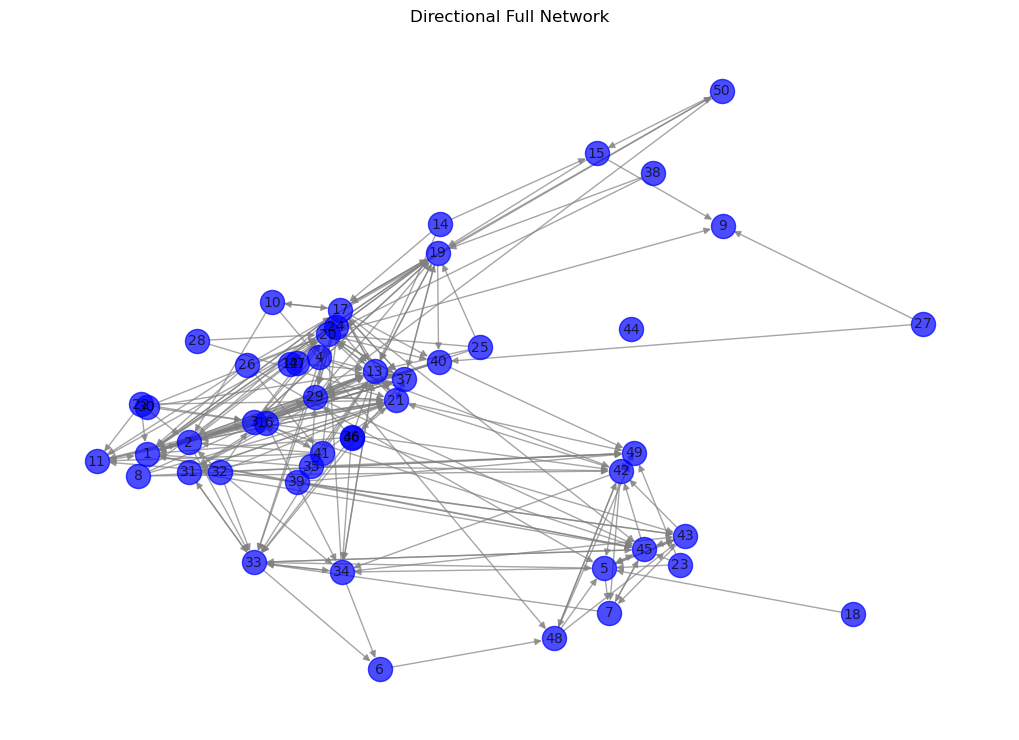

In [20]:
# Full network trajectory
nodes = {
        station_id: {'latitude': lat, 'longitude': lng} 
        for station_id, lat, lng in stations[['station_id', 'lat', 'lng']].itertuples(index=False)
    }

edges = [(segment[0],segment[1], demand) for segment, demand in segment_demand[['segment','segment_demand']].itertuples(index=False)]
graph_network(nodes, edges, 'Directional Full Network')

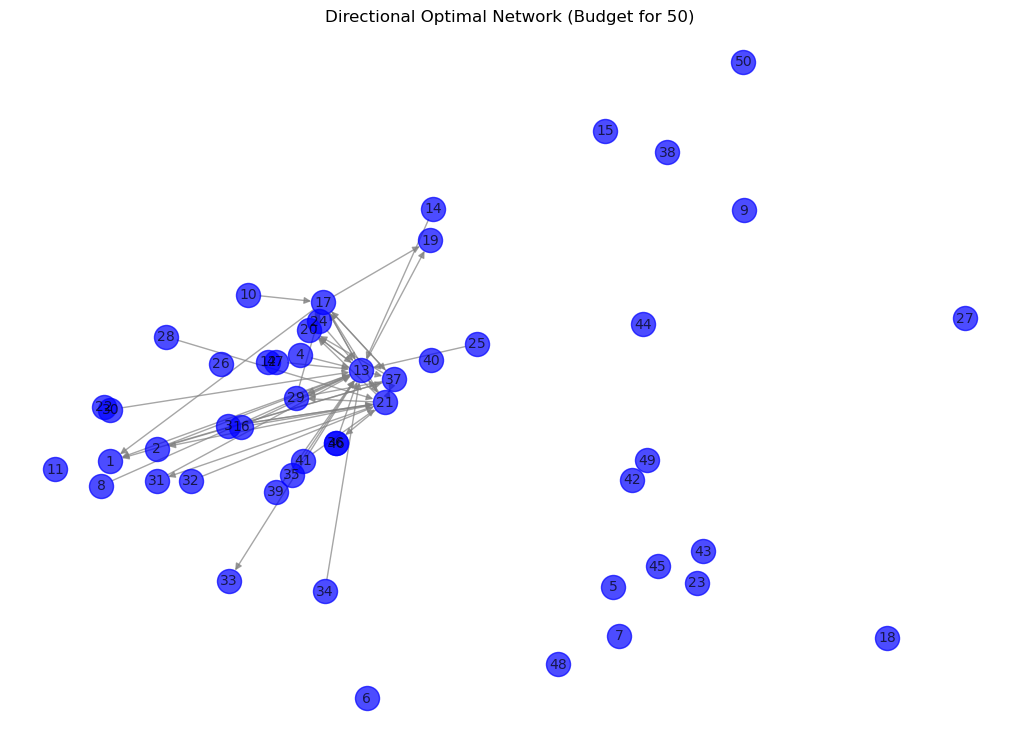

In [21]:
# Optimal network trajectory
nodes = {
        station_id: {'latitude': lat, 'longitude': lng} 
        for station_id, lat, lng in stations[['station_id', 'lat', 'lng']].itertuples(index=False)
    }

edges = []
for i in road_segments:
        if x[i].x == 1:
            edges.extend((start,end,segment_demand) for start,end,segment_demand in segment_demand.loc[segment_demand.segment_id == i, ['start','end','segment_demand']].itertuples(index=False))

graph_network(nodes, edges, 'Directional Optimal Network (Budget for 50)')

### 5. Sensitivity analysis

In [22]:
def optimize_bike_lane(road_segments, adjacent_segments, segment_demand_dict, intersection_stn_demand_dict,stations,segment_demand, B, # Fixed environment variables
                       segment_cost, # pseudo - constant variable (we change to understand results better, but would be fixed in real world)
                       lambda_param, env,
                       title # title for graph network
                       ):
    
    # Create the model
    model = gp.Model(env=env, name="Bike Lane Planning")

    # Decision variables
    x = model.addVars(road_segments, vtype=gp.GRB.BINARY, name="x")  # Whether to build a bike lane on segment i
    y = model.addVars(adjacent_segments, vtype=gp.GRB.BINARY, name="y")  # Adjacency utility

    # Objective function: maximize utility
    model.setObjective(
        sum(segment_demand_dict[i] * x[i] for i in road_segments) + 
        lambda_param * sum(intersection_stn_demand_dict[i, j] * y[i, j] for i, j in adjacent_segments),
        gp.GRB.MAXIMIZE
    )

    # Constraints
    # Budget constraint
    model.addConstr(sum(segment_cost[i] * x[i] for i in road_segments) <= B, "Budget")

    # Linearization constraints for y_ij
    for i, j in adjacent_segments:
        model.addConstr(y[i, j] >= x[i] + x[j] - 1, f"Linear1_{i}_{j}")
        model.addConstr(y[i, j] <= x[i], f"Linear2_{i}_{j}")
        model.addConstr(y[i, j] <= x[j], f"Linear3_{i}_{j}")

    # Solve the model
    model.optimize()
    
    # Collect results
    if model.status == gp.GRB.OPTIMAL:
        print("Optimal solution found!")
        print("Bike lanes on segments:")
        for i in road_segments:
            if x[i].x > 0.5:
                print(f"  Segment {i}, {x[i].x}")
        print("\nConnectivity utility:")
        for i, j in adjacent_segments:
            if y[i, j].x > 0.01:
                print(f"  Intersection ({i}, {j}): {y[i, j].x:.2f}")
        print(f"\nTotal utility: {model.objVal:.2f}")

        # Optimal network trajectory
        
        nodes = {
            station_id: {'latitude': lat, 'longitude': lng} 
            for station_id, lat, lng in stations[['station_id', 'lat', 'lng']].itertuples(index=False)
        }

        edges = []
        for i in road_segments:
                if x[i].x == 1:
                    edges.extend((start,end,segment_demand) for start,end,segment_demand in segment_demand.loc[segment_demand.segment_id == i, ['start','end','segment_demand']].itertuples(index=False))

        graph_network(nodes, edges, title)

    else:
        print("No optimal solution found.")    
    

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1355U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Academic license 2593580 - for non-commercial use only - registered to ri___@andrew.cmu.edu
Optimize a model with 766 rows, 480 columns and 2010 nonzeros
Model fingerprint: 0x2572515d
Variable types: 0 continuous, 480 integer (480 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+00, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Found heuristic solution: objective 1906.0000000
Presolve removed 765 rows and 414 columns
Presolve time: 0.01s
Presolved: 1 rows, 66 columns, 66 nonzeros
Variable types: 0 continuous, 66 integer (38 binary)
Found heuristic solution: objective 4167.0000000

Root relaxation: objective 4.302000e+03, 1 iterations, 0.00 seconds (0.00 work units)

    Nodes   

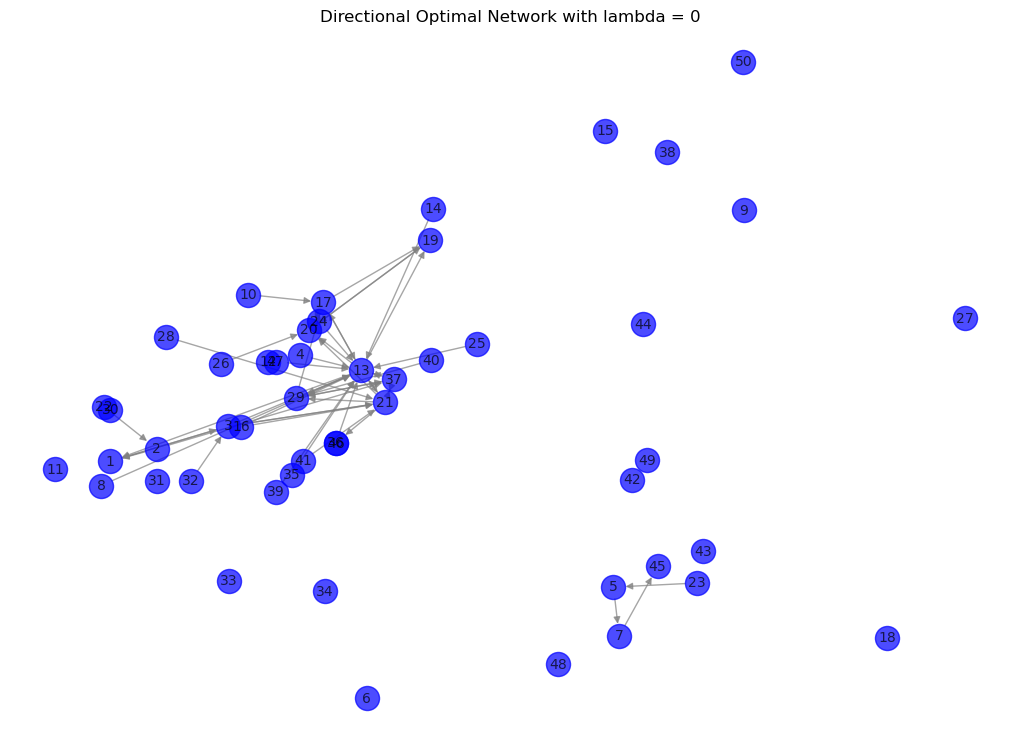

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1355U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Academic license 2593580 - for non-commercial use only - registered to ri___@andrew.cmu.edu
Optimize a model with 766 rows, 480 columns and 2010 nonzeros
Model fingerprint: 0x737c81af
Variable types: 0 continuous, 480 integer (480 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e-02, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Found heuristic solution: objective 1906.0000000
Presolve removed 255 rows and 23 columns
Presolve time: 0.01s
Presolved: 511 rows, 457 columns, 1222 nonzeros
Variable types: 0 continuous, 457 integer (454 binary)
Found heuristic solution: objective 3298.5300000

Root relaxation: objective 4.669590e+03, 70 iterations, 0.00 seconds (0.00 work units)

    N

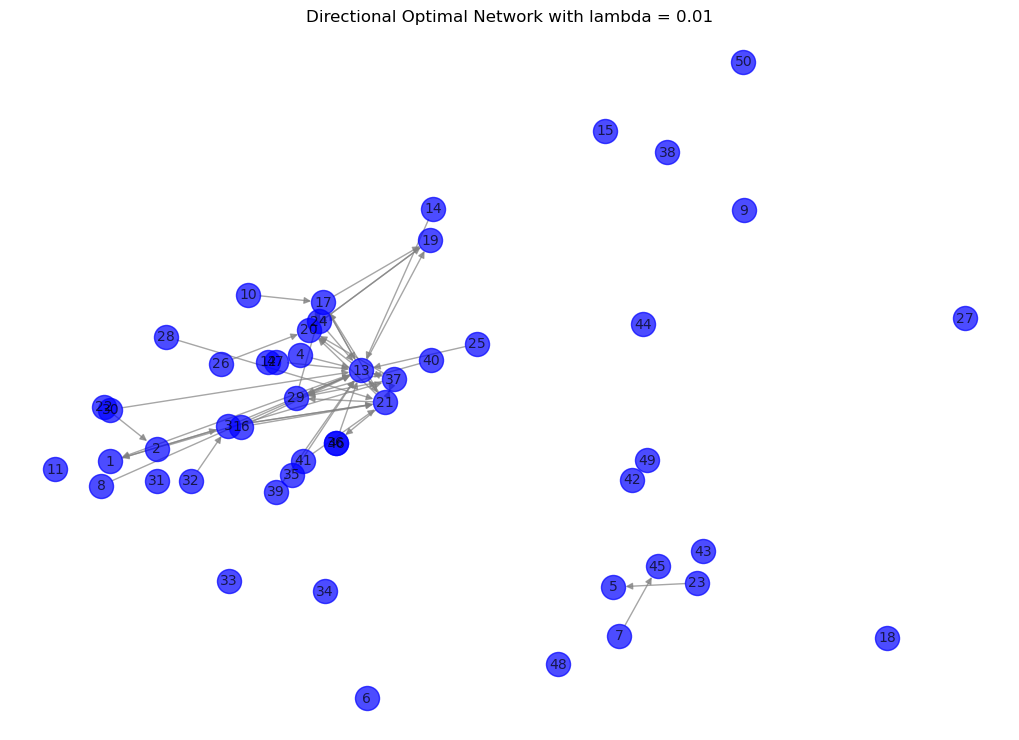

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1355U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Academic license 2593580 - for non-commercial use only - registered to ri___@andrew.cmu.edu
Optimize a model with 766 rows, 480 columns and 2010 nonzeros
Model fingerprint: 0xf67fce46
Variable types: 0 continuous, 480 integer (480 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [7e-02, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Found heuristic solution: objective 1906.0000000
Presolve removed 255 rows and 23 columns
Presolve time: 0.00s
Presolved: 511 rows, 457 columns, 1222 nonzeros
Variable types: 0 continuous, 457 integer (454 binary)
Found heuristic solution: objective 3847.7100000

Root relaxation: objective 7.163400e+03, 162 iterations, 0.00 seconds (0.00 work units)

    

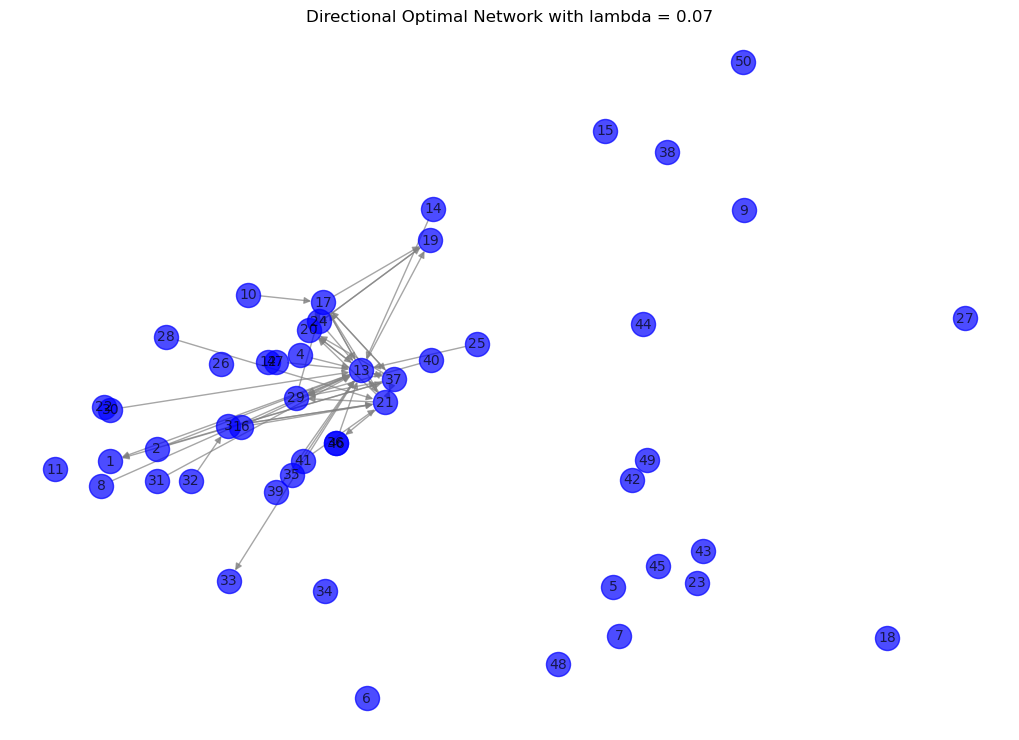

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1355U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Academic license 2593580 - for non-commercial use only - registered to ri___@andrew.cmu.edu
Optimize a model with 766 rows, 480 columns and 2010 nonzeros
Model fingerprint: 0xe4fa406f
Variable types: 0 continuous, 480 integer (480 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e-01, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Found heuristic solution: objective 1906.0000000
Presolve removed 255 rows and 23 columns
Presolve time: 0.01s
Presolved: 511 rows, 457 columns, 1222 nonzeros
Variable types: 0 continuous, 457 integer (454 binary)
Found heuristic solution: objective 4122.3000000

Root relaxation: objective 8.491400e+03, 190 iterations, 0.01 seconds (0.00 work units)

    

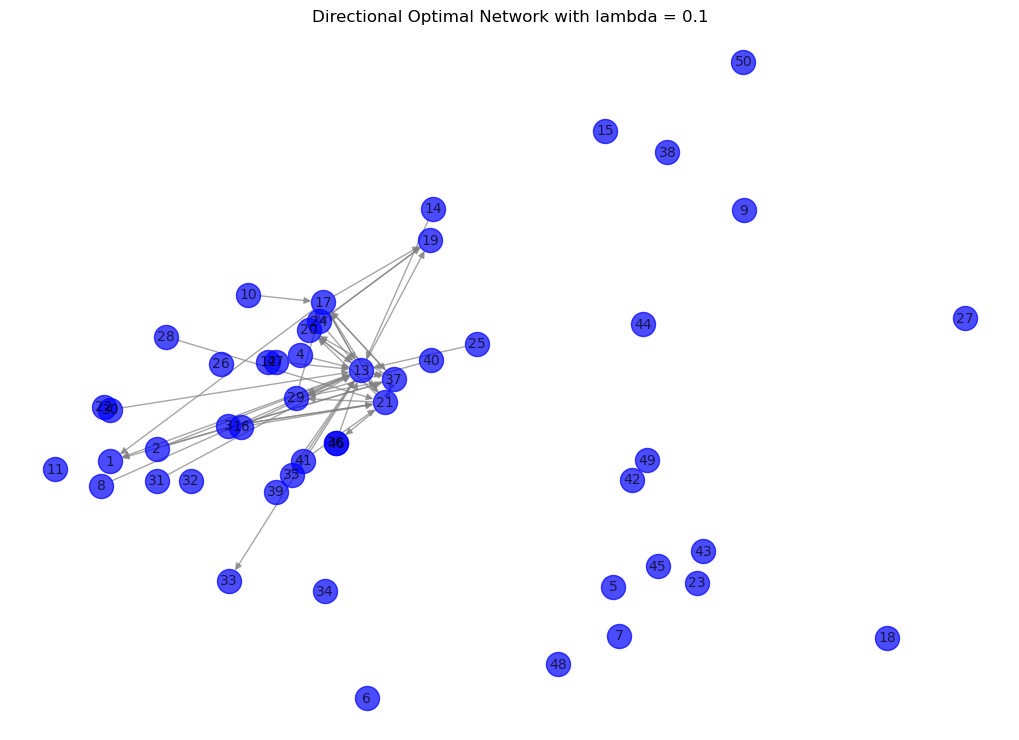

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1355U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Academic license 2593580 - for non-commercial use only - registered to ri___@andrew.cmu.edu
Optimize a model with 766 rows, 480 columns and 2010 nonzeros
Model fingerprint: 0x0a8ea8ca
Variable types: 0 continuous, 480 integer (480 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+00, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Found heuristic solution: objective 1906.0000000
Presolve removed 255 rows and 23 columns
Presolve time: 0.02s
Presolved: 511 rows, 457 columns, 1222 nonzeros
Variable types: 0 continuous, 457 integer (454 binary)
Found heuristic solution: objective 12360.000000

Root relaxation: objective 4.949800e+04, 37 iterations, 0.00 seconds (0.00 work units)

    N

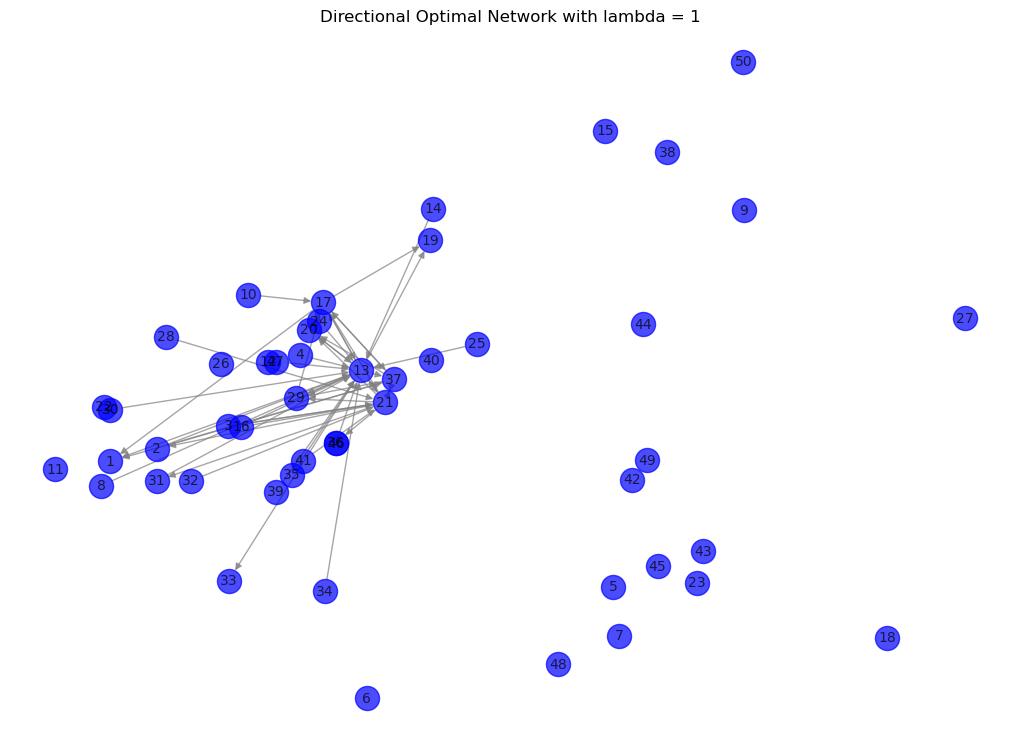

In [23]:
lambda_values = [0, 0.01, 0.07, 0.1, 1]  # Lambda values from 0 to 0.1
for lambda_param in lambda_values:
    optimize_bike_lane(road_segments, adjacent_segments, segment_demand_dict, intersection_stn_demand_dict,stations,segment_demand,B, # Fixed environment variables
                       segment_cost, # pseudo - constant variable (we change to understand results better, but would be fixed in real world)
                       lambda_param, env,
                       f'Directional Optimal Network with lambda = {lambda_param}'
                       )

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1355U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Academic license 2593580 - for non-commercial use only - registered to ri___@andrew.cmu.edu
Optimize a model with 766 rows, 480 columns and 2010 nonzeros
Model fingerprint: 0x0a8ea8ca
Variable types: 0 continuous, 480 integer (480 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+00, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Found heuristic solution: objective 1906.0000000
Presolve removed 255 rows and 23 columns
Presolve time: 0.01s
Presolved: 511 rows, 457 columns, 1222 nonzeros
Variable types: 0 continuous, 457 integer (454 binary)
Found heuristic solution: objective 12360.000000

Root relaxation: objective 4.949800e+04, 37 iterations, 0.00 seconds (0.00 work units)

    N

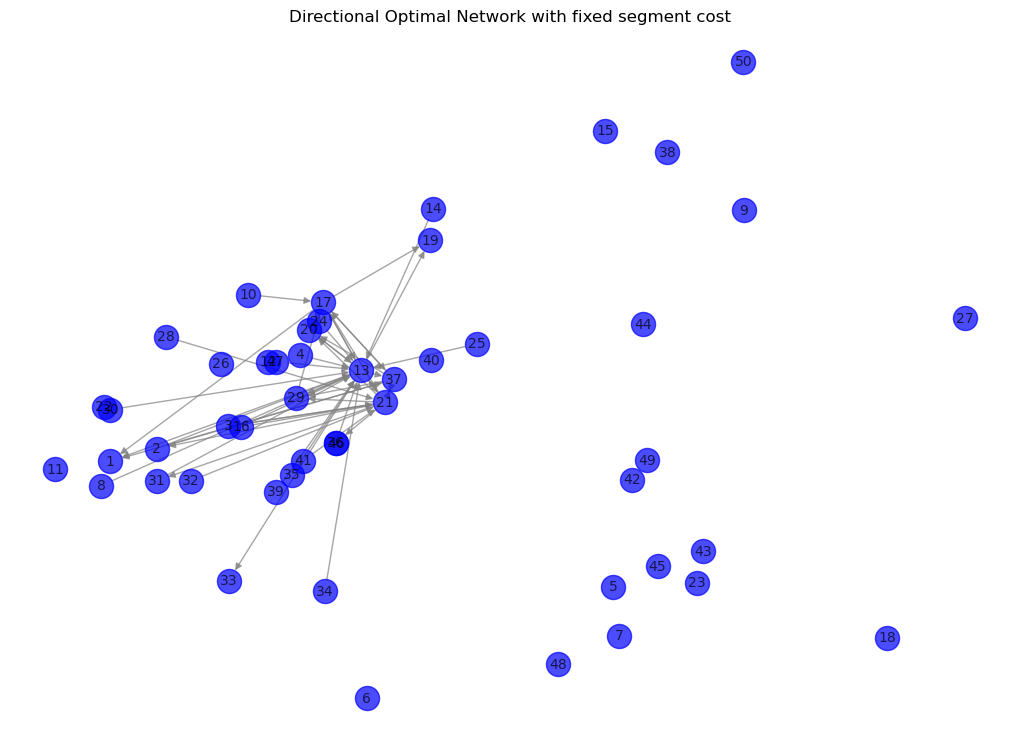

In [24]:
fixed_segment_cost = [30 for i in range(len(segment_demand['segment_id']))]
segment_cost = {k:c for k,c in zip(segment_demand['segment_id'], fixed_segment_cost)}

optimize_bike_lane(road_segments, adjacent_segments, segment_demand_dict, intersection_stn_demand_dict, stations, segment_demand, B, # Fixed environment variables
                    segment_cost, # pseudo - constant variable (we change to understand results better, but would be fixed in real world)
                    lambda_param, env,
                    f'Directional Optimal Network with fixed segment cost'
                    )

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1355U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Academic license 2593580 - for non-commercial use only - registered to ri___@andrew.cmu.edu
Optimize a model with 766 rows, 480 columns and 2010 nonzeros
Model fingerprint: 0xcce47088
Variable types: 0 continuous, 480 integer (480 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Found heuristic solution: objective 1803.0000000
Presolve removed 255 rows and 1 columns
Presolve time: 0.01s
Presolved: 511 rows, 479 columns, 1244 nonzeros
Variable types: 0 continuous, 479 integer (478 binary)
Found heuristic solution: objective 24966.000000

Root relaxation: objective 3.903271e+04, 62 iterations, 0.01 seconds (0.00 work units)

    No

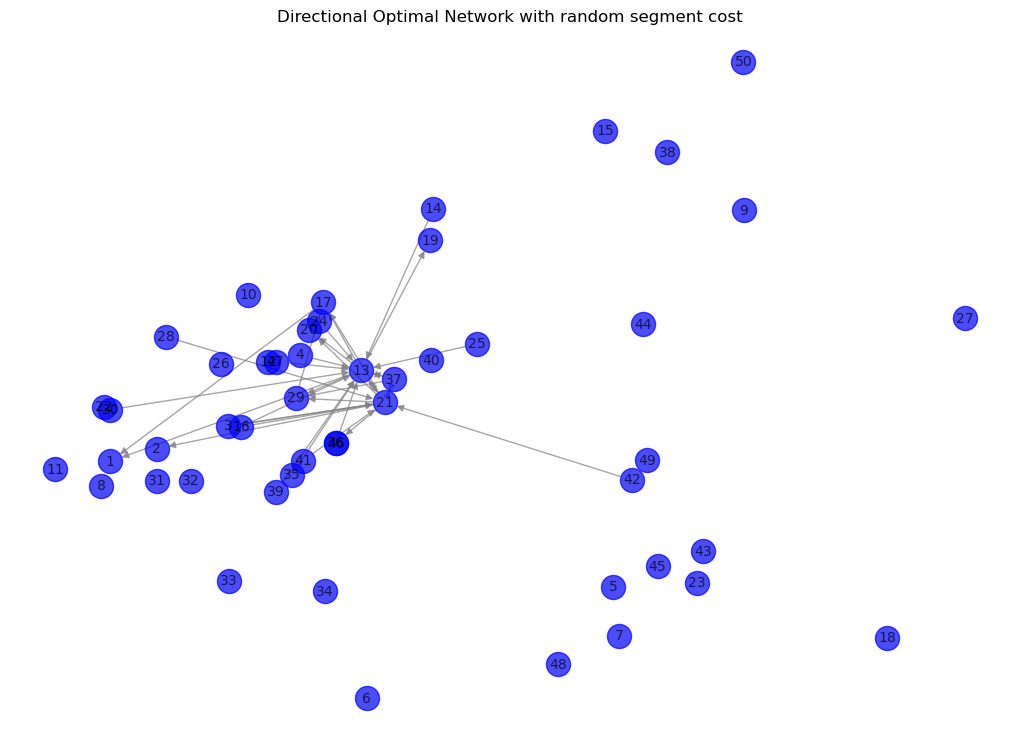

In [25]:
random_segment_cost = [random.randint(10,100) for i in range(len(segment_demand['segment_id']))]
segment_cost = {k:c for k,c in zip(segment_demand['segment_id'], random_segment_cost)}

optimize_bike_lane(road_segments, adjacent_segments, segment_demand_dict, intersection_stn_demand_dict,stations,segment_demand,B, # Fixed environment variables
                    segment_cost, # pseudo - constant variable (we change to understand results better, but would be fixed in real world)
                    lambda_param, env,
                    f'Directional Optimal Network with random segment cost'
                    )